In [ ]:
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 2.0 MB/s eta 0:00:00


In [ ]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras

In [ ]:
import albumentations
albumentations.__version__

'1.2.1'

In [ ]:
from google.colab import drive

drive = drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Defining a data directory
DATA_DIR = './drive/My Drive/FDL-Kaggle/'

In [ ]:
#Defining the data directories of training, validation and testing dataset

x_train_dir = os.path.join(DATA_DIR, '_images2')
y_train_dir = os.path.join(DATA_DIR, '_masks2')

x_valid_dir = os.path.join(DATA_DIR, 'Validation2')
y_valid_dir = os.path.join(DATA_DIR, 'validation2_m')

x_test_dir = os.path.join(DATA_DIR, 'test_val_images2')
y_test_dir = os.path.join(DATA_DIR, 'test_val_masks2')

In [ ]:
CLASSES = ['Background','Property Roof','Secondary Structure','Swimming Pool','Vehicle','Grass','Trees / Shrubs','Solar Panels','Chimney','Street Light','Window','Satellite Antenna','Garbage Bins','Trampoline','Road / Highway','Under Construction / In Progress Status','Power Lines & Cables','Bridge','Water Tank / Oil Tank','Parking Area - Commercial','Sports Complex / Arena','Industrial Site','Dense Vegetation / Forest','Water Body','Flooded','Boat','Parking Area']

In [ ]:
# helper function for data visualization
#This function helps in visualizing images
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    print(n)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization - 
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    #Defining all the classes 
    CLASSES=['Background','Property Roof','Secondary Structure','Swimming Pool','Vehicle','Grass','Trees / Shrubs',
               'Solar Panels','Chimney','Street Light','Window','Satellite Antenna','Garbage Bins','Trampoline',
               'Road / Highway','Under Construction / In Progress Status','Power Lines & Cables','Bridge',
               'Water Tank / Oil Tank','Parking Area - Commercial','Sports Complex / Arena','Industrial Site',
               'Dense Vegetation / Forest','Water Body','Flooded','Boat','Parking Area']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_ids = os.listdir(images_dir)
        self.mask_ids = os.listdir(masks_dir)
        self.images_fps = sorted([os.path.join(images_dir, image_id) for image_id in self.image_ids])
        self.masks_fps = sorted([os.path.join(masks_dir, mask_id) for mask_id in self.mask_ids])
        print(self.images_fps)
        print(self.masks_fps)

        self.class_values = [self.CLASSES.index(cls) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image, dsize=(384, 480), interpolation = cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, dsize=(384, 480), interpolation = cv2.INTER_NEAREST)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        '''
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        '''
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.image_ids)

In [ ]:
#Defining a class of Dataloader - This dataloader is used for loading the training and validation sets

class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

['./drive/My Drive/FDL-Kaggle/_images2/10172.tif', './drive/My Drive/FDL-Kaggle/_images2/10174.tif', './drive/My Drive/FDL-Kaggle/_images2/10566.tif', './drive/My Drive/FDL-Kaggle/_images2/10808.tif', './drive/My Drive/FDL-Kaggle/_images2/10810.tif', './drive/My Drive/FDL-Kaggle/_images2/10817.tif', './drive/My Drive/FDL-Kaggle/_images2/6411.tif', './drive/My Drive/FDL-Kaggle/_images2/6412.tif', './drive/My Drive/FDL-Kaggle/_images2/6413.tif', './drive/My Drive/FDL-Kaggle/_images2/6416.tif', './drive/My Drive/FDL-Kaggle/_images2/6419.tif', './drive/My Drive/FDL-Kaggle/_images2/6420.tif', './drive/My Drive/FDL-Kaggle/_images2/6421.tif', './drive/My Drive/FDL-Kaggle/_images2/6422.tif', './drive/My Drive/FDL-Kaggle/_images2/6424.tif', './drive/My Drive/FDL-Kaggle/_images2/6426.tif', './drive/My Drive/FDL-Kaggle/_images2/6431.tif', './drive/My Drive/FDL-Kaggle/_images2/6433.tif', './drive/My Drive/FDL-Kaggle/_images2/6435.tif', './drive/My Drive/FDL-Kaggle/_images2/6437.tif', './drive/My D

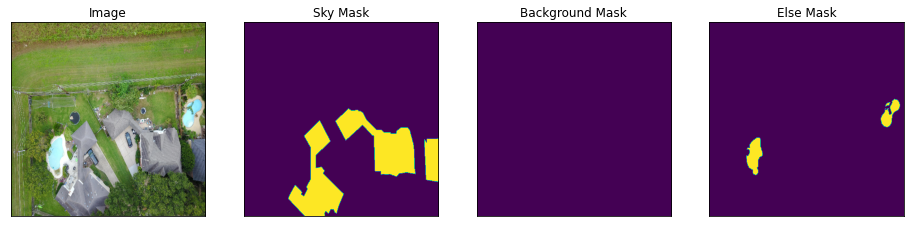

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

image, mask = dataset[5] # get some sample
visualize(
    image=image,
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
    else_mask=mask[..., 3].squeeze()
)

In [ ]:
import albumentations as A

Defining some augmentation steps. Since our training dataset is small.  It is common knowledge that the more data an ML algorithm has access to, the more effective it can be. Even when the data is of lower quality, algorithms
can actually perform better, as long as useful data can be extracted by the model from the original data set.
we are apply the following different augmentations:

- horizontal flip
- affine transforms
- perspective transforms
- brightness/contrast/colors manipulations
- image bluring and sharpening
- gaussian noise
- random crops

We also check whether by removing data augmentation techniques if the score improves. 

In [ ]:

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
            
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0, p=1, border_mode=0),

        #A.PadIfNeeded(min_height=512, min_width=512, border_mode=0),
        A.RandomCrop(height=480, width=384),

        #A.IAAAdditiveGaussianNoise(p=0.2),
        #A.IAAPerspective(p=0.5),
        A.IAASharpen(p=1.5),
        A.RandomContrast(p=1),
        
        #A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(480, 384)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

['./drive/My Drive/FDL-Kaggle/_images2/10172.tif', './drive/My Drive/FDL-Kaggle/_images2/10174.tif', './drive/My Drive/FDL-Kaggle/_images2/10566.tif', './drive/My Drive/FDL-Kaggle/_images2/10808.tif', './drive/My Drive/FDL-Kaggle/_images2/10810.tif', './drive/My Drive/FDL-Kaggle/_images2/10817.tif', './drive/My Drive/FDL-Kaggle/_images2/6411.tif', './drive/My Drive/FDL-Kaggle/_images2/6412.tif', './drive/My Drive/FDL-Kaggle/_images2/6413.tif', './drive/My Drive/FDL-Kaggle/_images2/6416.tif', './drive/My Drive/FDL-Kaggle/_images2/6419.tif', './drive/My Drive/FDL-Kaggle/_images2/6420.tif', './drive/My Drive/FDL-Kaggle/_images2/6421.tif', './drive/My Drive/FDL-Kaggle/_images2/6422.tif', './drive/My Drive/FDL-Kaggle/_images2/6424.tif', './drive/My Drive/FDL-Kaggle/_images2/6426.tif', './drive/My Drive/FDL-Kaggle/_images2/6431.tif', './drive/My Drive/FDL-Kaggle/_images2/6433.tif', './drive/My Drive/FDL-Kaggle/_images2/6435.tif', './drive/My Drive/FDL-Kaggle/_images2/6437.tif', './drive/My D

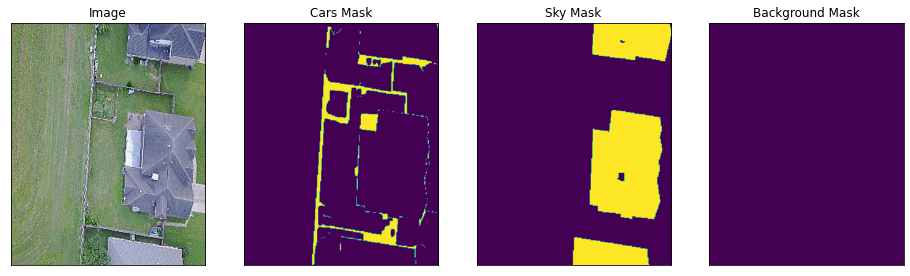

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES, augmentation=get_training_augmentation())

image, mask = dataset[8] # get some sample
print(image.shape)
print(mask.shape)
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

In [ ]:
import segmentation_models as sm

We picked and experimented with different backbones. Backbone_name is the name of classification model used as feature extractor to build segmentation model.

In [ ]:

#BACKBONE = 'efficientnetb3'
#BACKBONE = 'resnet34'
#BACKBONE = 'resnet52'
#BACKBONE = 'densenet169'
BACKBONE = 'seresnet101'
#BACKBONE = 'mobilenet'
#BACKBONE = 'vgg16'
#BACKBONE = 'vgg19'
#BACKBONE = 'inceptionnetv3'
#BACKBONE = 'inceptionresnetv2'
#BACKBONE = 'senet154'
#BACKBONE = 'seresnet101'

CLASSES = CLASSES
LR = 0.0001
EPOCHS = 50

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
n_classes = len(CLASSES)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)


['./drive/My Drive/FDL-Kaggle/_images2/10172.tif', './drive/My Drive/FDL-Kaggle/_images2/10174.tif', './drive/My Drive/FDL-Kaggle/_images2/10566.tif', './drive/My Drive/FDL-Kaggle/_images2/10808.tif', './drive/My Drive/FDL-Kaggle/_images2/10810.tif', './drive/My Drive/FDL-Kaggle/_images2/10817.tif', './drive/My Drive/FDL-Kaggle/_images2/6411.tif', './drive/My Drive/FDL-Kaggle/_images2/6412.tif', './drive/My Drive/FDL-Kaggle/_images2/6413.tif', './drive/My Drive/FDL-Kaggle/_images2/6416.tif', './drive/My Drive/FDL-Kaggle/_images2/6419.tif', './drive/My Drive/FDL-Kaggle/_images2/6420.tif', './drive/My Drive/FDL-Kaggle/_images2/6421.tif', './drive/My Drive/FDL-Kaggle/_images2/6422.tif', './drive/My Drive/FDL-Kaggle/_images2/6424.tif', './drive/My Drive/FDL-Kaggle/_images2/6426.tif', './drive/My Drive/FDL-Kaggle/_images2/6431.tif', './drive/My Drive/FDL-Kaggle/_images2/6433.tif', './drive/My Drive/FDL-Kaggle/_images2/6435.tif', './drive/My Drive/FDL-Kaggle/_images2/6437.tif', './drive/My D

In [ ]:

train_dataloader = Dataloder(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
# check shapes for errors
assert train_dataloader[0][0].shape == (1, 480, 384, 3)
assert train_dataloader[0][1].shape == (1, 480, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10),
              keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)]

(2, 480, 384, 3)
(2, 480, 384, 27)


In [ ]:
# define network parameters
n_classes = (len(CLASSES))  # case for binary and multiclass segmentation
#activation = 'sigmoid' if n_classes == 1 else 'softmax'
activation = 'softmax'
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of d19885ff4a710c122648d3b5c3b684e4 so we will re-download the data.
219055592/219055592 [==============================] - 51s 0us/step


In [ ]:
# define optomizer
optim = keras.optimizers.Adamax(LR)
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss()
jaccard_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss +jaccard_loss+focal_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=['accuracy'])

In [ ]:
import pandas as pd

df = pd.read_csv('train.csv')
df['image_name'] = df['image:01'].str.split('/').apply(lambda x: x[-1])
df = df.drop_duplicates(['image_name','label'],keep= 'last')
df = df.groupby('image_name').size().sort_values(ascending=False) \
  .reset_index(name='label_counts')
df.head()
df.to_csv('label_counts.csv', encoding='utf-8', index=False)

In [ ]:
df = pd.read_csv('label_counts.csv')
df = df.sort_values(by=['image_name'], ascending=False)
df.head()
df.to_csv('label_counts2.csv', encoding='utf-8', index=False)

In [ ]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader)
)

Epoch 1/100
119/119 [==============================] - 142s 1s/step - loss: 1.9587 - accuracy: 0.3065 - val_loss: 1.9320 - val_accuracy: 0.3041
Epoch 2/100
119/119 [==============================] - 112s 939ms/step - loss: 1.9127 - accuracy: 0.4336 - val_loss: 1.9134 - val_accuracy: 0.3392
Epoch 3/100
119/119 [==============================] - 114s 960ms/step - loss: 1.8888 - accuracy: 0.4686 - val_loss: 1.8938 - val_accuracy: 0.3612
Epoch 4/100
119/119 [==============================] - 113s 952ms/step - loss: 1.8728 - accuracy: 0.4662 - val_loss: 1.8869 - val_accuracy: 0.3572
Epoch 5/100
119/119 [==============================] - 113s 946ms/step - loss: 1.8577 - accuracy: 0.4330 - val_loss: 1.8784 - val_accuracy: 0.3774
Epoch 6/100
119/119 [==============================] - 110s 921ms/step - loss: 1.8489 - accuracy: 0.4167 - val_loss: 1.8806 - val_accuracy: 0.3581
Epoch 7/100
119/119 [==============================] - 108s 903ms/step - loss: 1.8394 - accuracy: 0.4303 - val_loss: 1.89

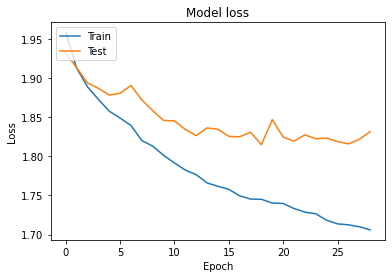

In [ ]:
# Plot training & validation iou_score values

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#We loaded the small test set (manually defined whereby we picked 5 random images from the training set to check the accuracy of our model)
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input))

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

['./drive/My Drive/FDL-Kaggle/test_val_images2/6664.tif', './drive/My Drive/FDL-Kaggle/test_val_images2/7238.tif', './drive/My Drive/FDL-Kaggle/test_val_images2/7469.tif', './drive/My Drive/FDL-Kaggle/test_val_images2/7682.tif', './drive/My Drive/FDL-Kaggle/test_val_images2/8361.tif', './drive/My Drive/FDL-Kaggle/test_val_images2/9459.tif']
['./drive/My Drive/FDL-Kaggle/test_val_masks2/6664.png', './drive/My Drive/FDL-Kaggle/test_val_masks2/7238.png', './drive/My Drive/FDL-Kaggle/test_val_masks2/7469.png', './drive/My Drive/FDL-Kaggle/test_val_masks2/7682.png', './drive/My Drive/FDL-Kaggle/test_val_masks2/8361.png', './drive/My Drive/FDL-Kaggle/test_val_masks2/9459.png']


/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [ ]:
# load best weights
model.load_weights('best_model.h5') 

In [ ]:
#Checking the loss, iou score and f1 score on the traindata set
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

<ipython-input-82-2f59340d8146>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 1.7564
mean iou_score: 0.63613


In [ ]:
x_test_dir_final = os.path.join(DATA_DIR, 'test_images')

In [ ]:
class Dataset_test:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        class_values (list): values of classes to extract from segmentation mask
    """
    
    CLASSES=CLASSES
    yes = 0
    def __init__(
            self, 
            images_dir, 
            classes=None,
            augmentation=None, 
            preprocessing=None, 
    ):
        self.image_ids = os.listdir(images_dir)
        print(self.image_ids)
        self.images_fps = sorted([os.path.join(images_dir, image_id) for image_id in self.image_ids])
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])

        if image.shape == (3000, 4000, 3):
            self.yes+=1
            my_img.append(self.images_fps[i].split('/')[-1])
        image = cv2.resize(image, dsize=(384, 384), interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        return image, self.image_ids[i].split('.')[0]
        
    def __len__(self):
        return len(self.image_ids)
    def __getYes__(self):
      return self.yes

In [ ]:
test_dataset_final = Dataset_test(
    x_test_dir_final, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

['6456.tif', '6447.tif', '6703.tif', '6603.tif', '6691.tif', '7241.tif', '7245.tif', '7258.tif', '7298.tif', '7310.tif', '7306.tif', '7415.tif', '7489.tif', '6414.tif', '7751.tif', '8786.tif', '8860.tif', '10300.tif', '6715.tif', '6608.tif', '6427.tif', '6580.tif', '6794.tif', '6710.tif', '7691.tif', '7301.tif', '6829.tif', '7650.tif', '9080.tif', '6796.tif', '8821.tif', '6946.tif', '7609.tif', '6574.tif', '6469.tif', '9079.tif', '6820.tif', '7336.tif', '6548.tif', '7320.tif', '6569.tif', '7525.tif', '6645.tif', '6499.tif', '6659.tif', '9103.tif', '6979.tif', '6649.tif', '6639.tif', '7305.tif', '7315.tif', '7473.tif', '8431.tif', '6939.tif', '6933.tif', '9795.tif', '7526.tif', '8955.tif', '7590.tif', '7899.tif', '9045.tif', '7429.tif', '7252.tif', '7597.tif', '7596.tif', '7616.tif', '7567.tif', '9082.tif', '7318.tif', '8777.tif', '9036.tif', '8447.tif', '8362.tif', '10184.tif', '9055.tif']


75
image shape :  (384, 384, 3)
New_image shape :  (1, 384, 384, 3)
1/1 [==============================] - 1s 1s/step
(1, 384, 384, 27)
(1, 384, 384, 3)
2


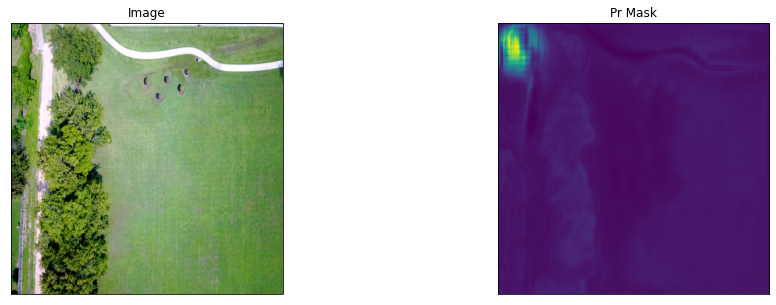

2


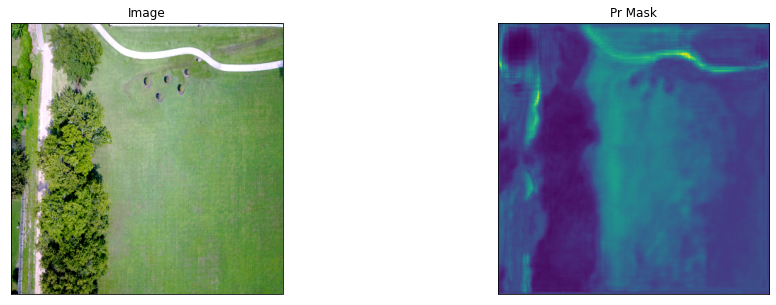

2


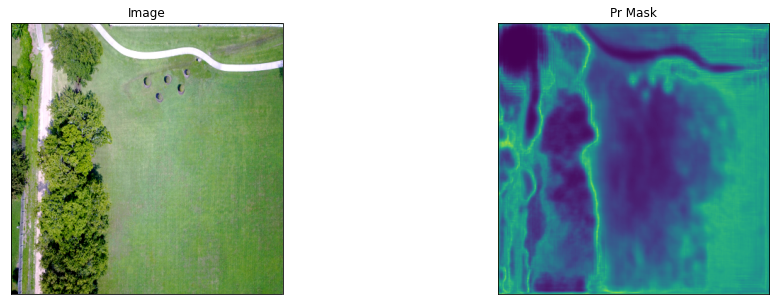

2


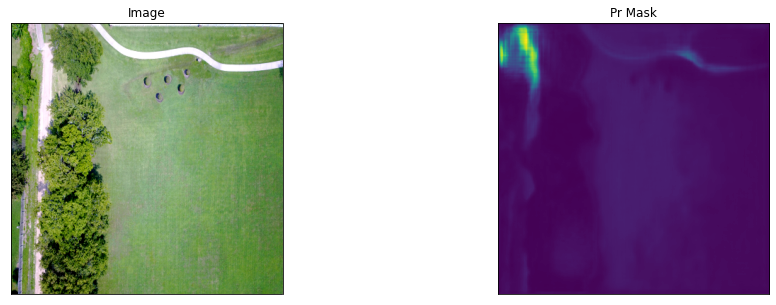

2


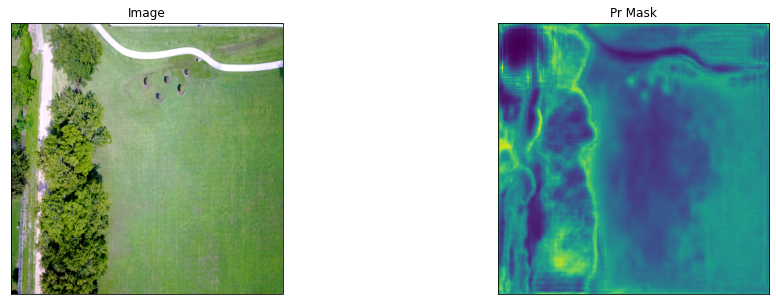

2


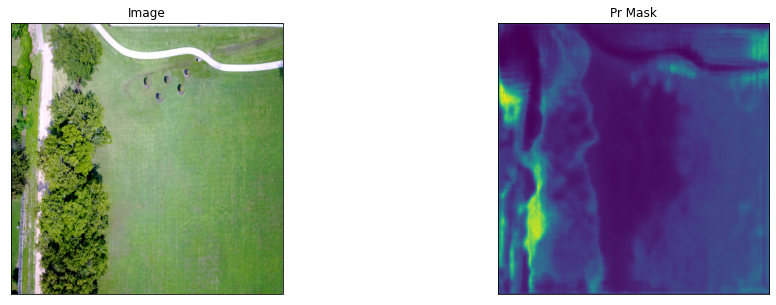

2


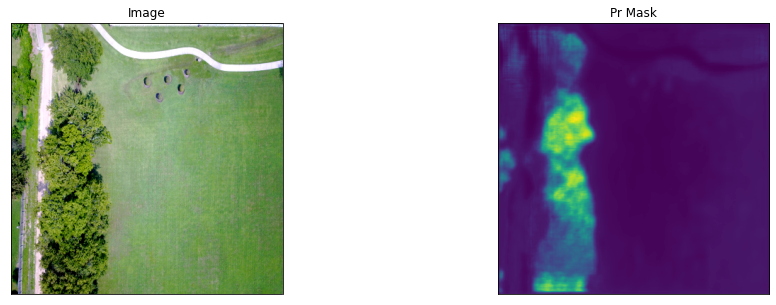

2


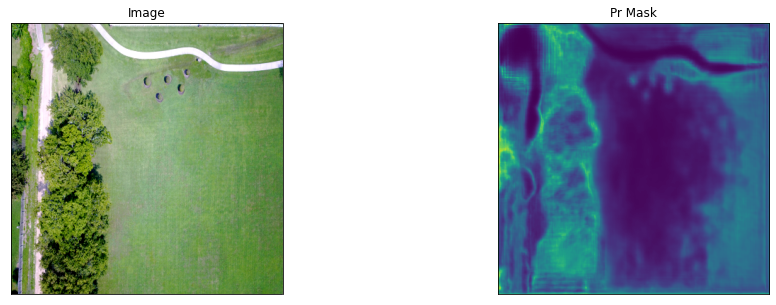

2


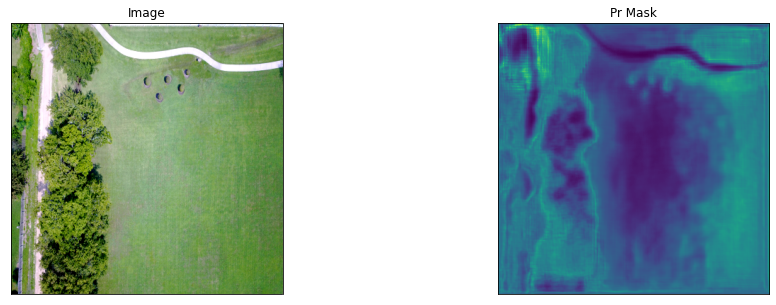

2


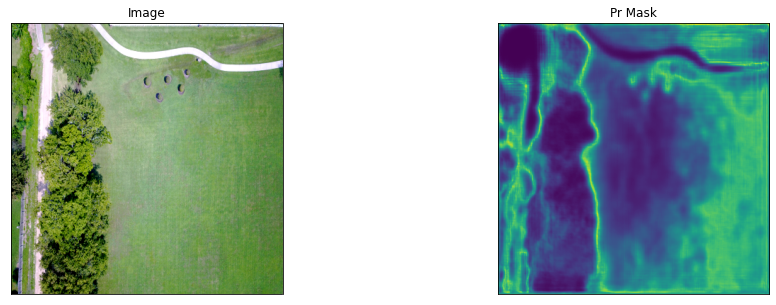

2


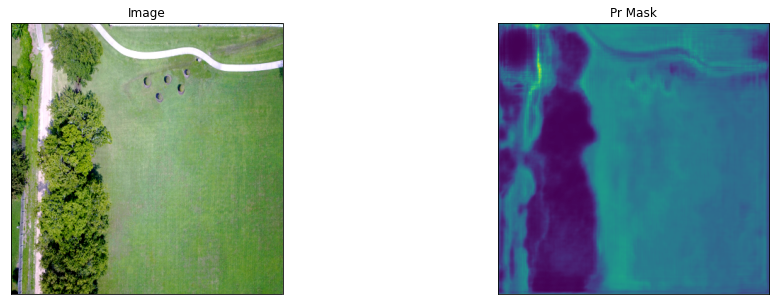

2


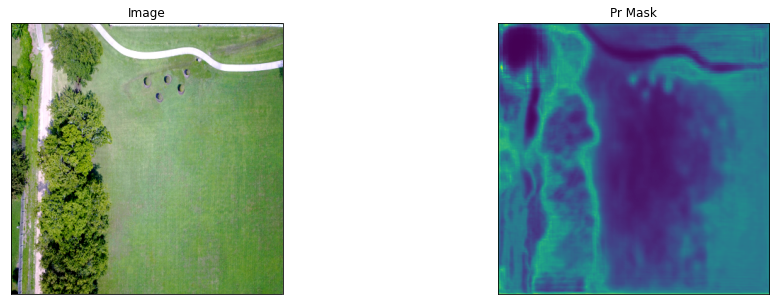

2


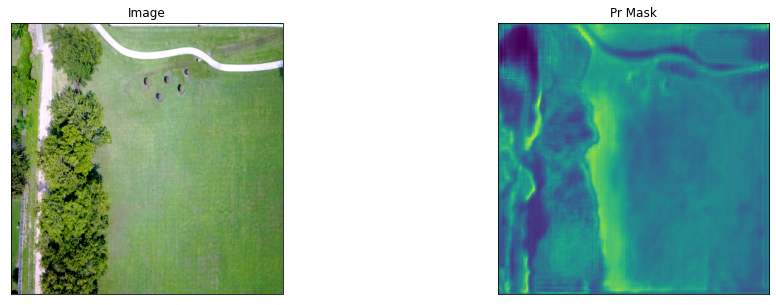

2


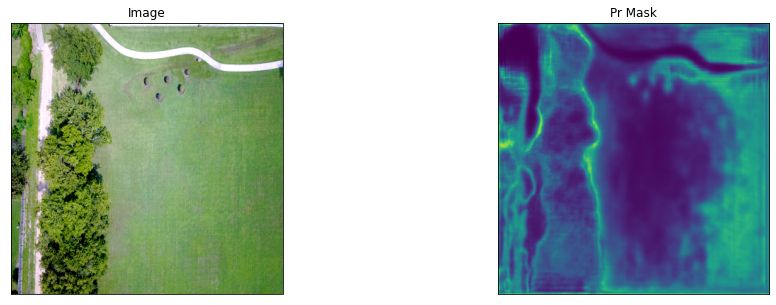

2


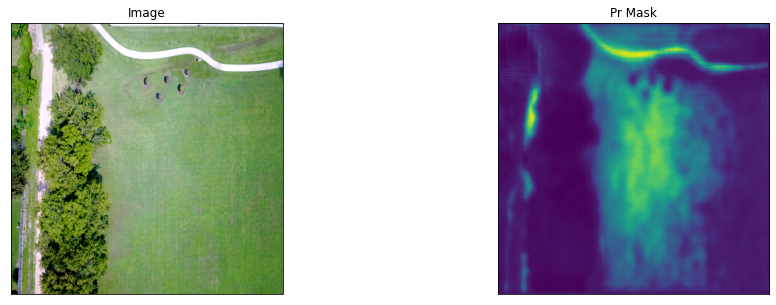

2


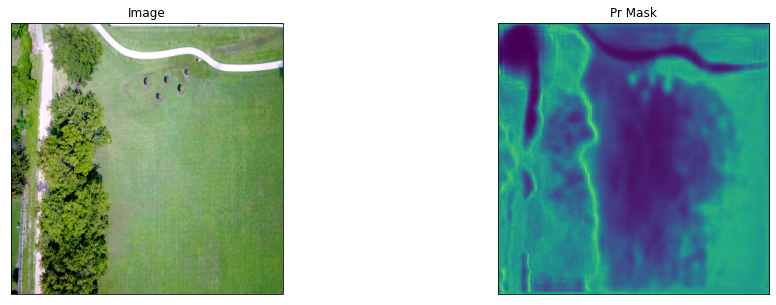

2


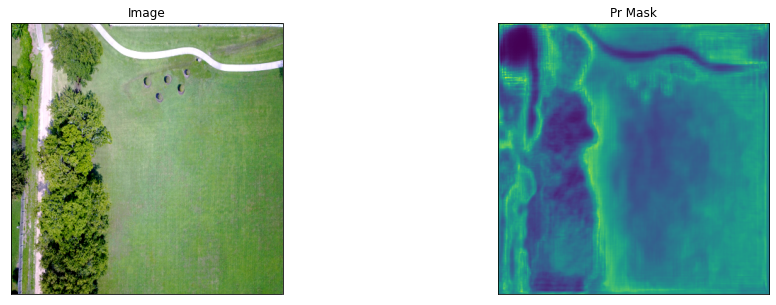

2


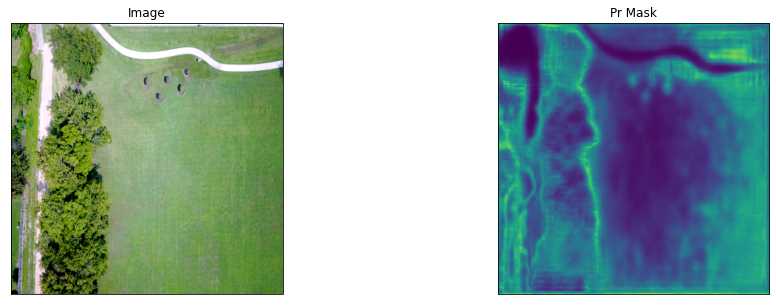

2


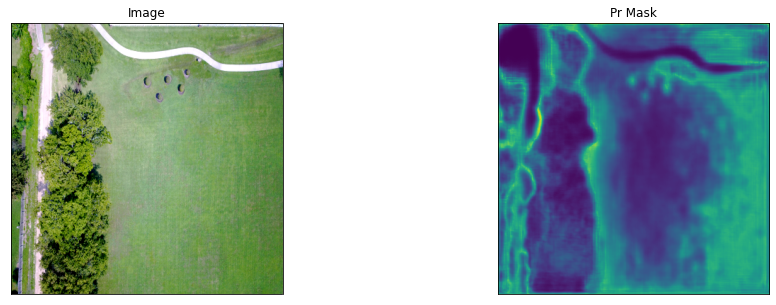

2


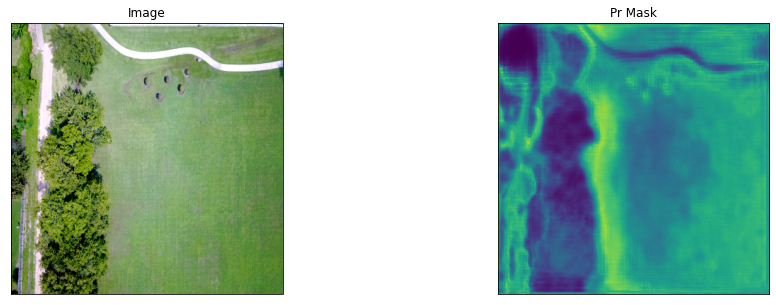

2


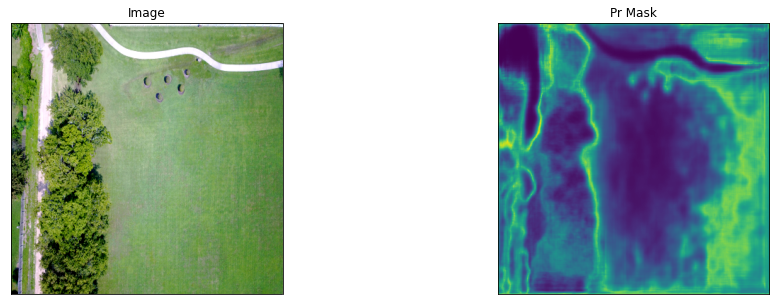

2


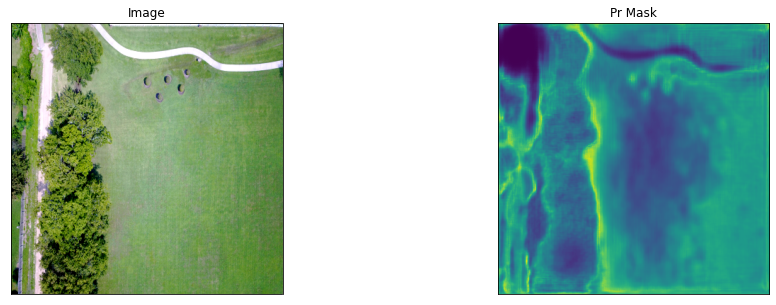

2


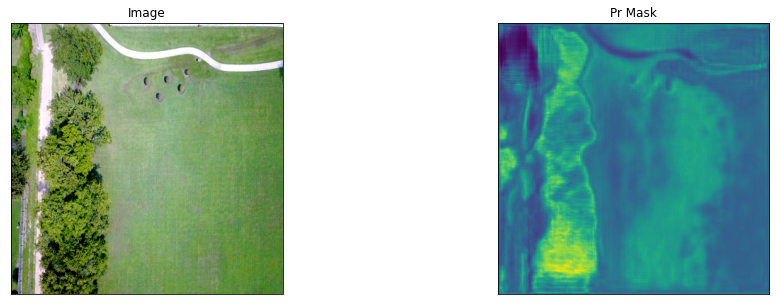

2


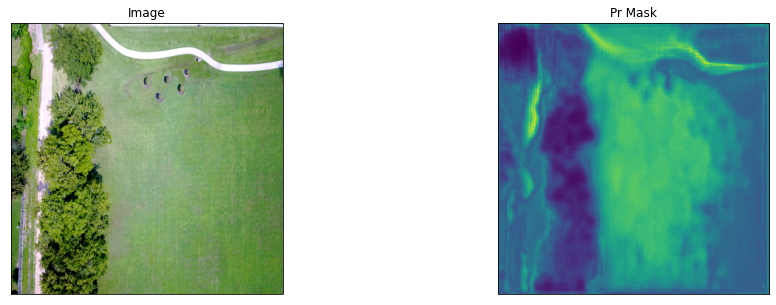

2


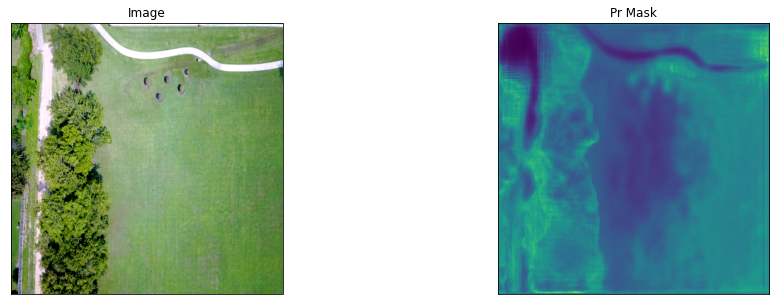

6456


In [ ]:
n = len(test_dataset_final)
print(n)
for i in range(1):
  
    image, id = test_dataset_final[i]
    print("image shape : ", image.shape)
    image = np.expand_dims(image, axis=0)
    print("New_image shape : ", image.shape)
    pr_mask = model.predict(image)
    print(pr_mask.shape)
    print(image.shape)
    for j in range(25):
      visualize(
          image=denormalize(image.squeeze()),
          pr_mask=pr_mask[:,:,:,j].squeeze()
      )
    print(id)

In [ ]:
 #Getting the image from the predicted masks. Defining a function that will restack all the masks together
def restack_images(pr_mask): 
  mask = np.zeros((pr_mask.shape[1], pr_mask.shape[2]))
  for y in range(pr_mask.shape[1]):
      for x in range(pr_mask.shape[2]):
        #for i in range(6):
          #max_ = np.argmax(pr_mask[i,y,x,:])
        max_ = np.argmax(pr_mask[0,y,x,:])
        mask[y,x] = max_
  return mask  

In [ ]:
my_img = ['10184','10300','6414','6427','6447','6456','6469','6499','6548','6569','6639','6645','6649','6659','6703','6794','6796','6820','6829','6933','6939','6946','6979','7298','7473','7650','7691','7751','7899','8362','8431','8447','8777','8786','8821','8860','8955','9036','9045','9055','9079','9080','9082','9103','9795']

In [ ]:
len(my_img)

45

In [ ]:
#Defining a function to save all the masks that we derived from our predictions
import os

from PIL import Image
import numpy as np

def save_images(data):
  n = len(data)
  print(n)
  for i in range(n):
    image, id = data[i]
    image = np.expand_dims(image, axis=0)

    pr_mask = model.predict(image)
    mask = restack_images(pr_mask)
    img = Image.fromarray(mask)
    img = img.convert("RGB")
    print(img)
    print(i)
    file_name = '/content/drive/MyDrive/FDL-Kaggle/predictions/'+id+'.png'
    print(file_name)
    img.save(file_name)

In [ ]:
save_images(test_dataset_final)

75
1/1 [==============================] - 5s 5s/step
<PIL.Image.Image image mode=RGB size=384x384 at 0x7F22BB42B5B0>
0
/content/drive/MyDrive/FDL-Kaggle/predictions/6456.png
1/1 [==============================] - 0s 40ms/step
<PIL.Image.Image image mode=RGB size=384x384 at 0x7F2518122B20>
1
/content/drive/MyDrive/FDL-Kaggle/predictions/6447.png
1/1 [==============================] - 0s 42ms/step
<PIL.Image.Image image mode=RGB size=384x384 at 0x7F22BB42B5B0>
2
/content/drive/MyDrive/FDL-Kaggle/predictions/6703.png
1/1 [==============================] - 0s 40ms/step
<PIL.Image.Image image mode=RGB size=384x384 at 0x7F22BABF4BB0>
3
/content/drive/MyDrive/FDL-Kaggle/predictions/6603.png
1/1 [==============================] - 0s 39ms/step
<PIL.Image.Image image mode=RGB size=384x384 at 0x7F22BABEB520>
4
/content/drive/MyDrive/FDL-Kaggle/predictions/6691.png
1/1 [==============================] - 0s 48ms/step
<PIL.Image.Image image mode=RGB size=384x384 at 0x7F22C17D84F0>
5
/content/drive/M

In [ ]:
test_mask_dir = '/content/drive/MyDrive/FDL-Kaggle/predictions/'
test_masks=[]
c = 0
c1 = 0
std_dim = (4000 , 3000)
diff_dim = (4592, 3072)
for path, subdirs, files in os.walk(test_mask_dir): 
    dirname = path.split(os.path.sep)[-1]
    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                #img_names.append(image_name[:-4])
                
                mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as BG
                
                if mask_name[:-4] in my_img:
                  c+=1
                  mask = cv2.resize(mask, std_dim, interpolation = cv2.INTER_NEAREST)
                else:
                  mask = cv2.resize(mask, diff_dim, interpolation = cv2.INTER_NEAREST)
                #mask = Image.fromarray(mask)
                test_masks.append(mask)
                mask = np.array(mask)
                cv2.imwrite("/content/drive/MyDrive/FDL-Kaggle/final_test_masks/"+mask_name,mask)    
print(len(test_masks),c)

75 45


In [ ]:
i=1

In [ ]:
import tarfile

tar = tarfile.open("submission"+str(i)+".tar", "w")
print(tar)
for root, dir, files in os.walk('/content/drive/MyDrive/FDL-Kaggle/final_test_masks'):
    print('x')
    for  file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()

x
